In [2]:
from IPython import get_ipython
get_ipython().magic('reset -sf')

In [3]:
import pandas as pd
import numpy as np
# np.set_printoptions(suppress=True) # чтоб без e
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
import time
from pylab import *

%matplotlib inline

__Блок обработки данных__,
запущено на старых данных 2018 года.

У них несколько проблем, __проблема первая__: нужно было выровнить Москву и область, умножив значения москвичей на 1.62. Добавили столбец принадлежности Москве, умножили. __Вторая проблема__: в этих данных i с j не всегда пересекаются. Не получается вернуть издержку. Возвращаю в таких случаях 0.

In [4]:
df = pd.read_csv('traffic_moscow.csv', header=None)
df.columns = ["i", "j", "amt", "t", "s"]

def make_index(i, j):
    residents = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    if int(i) in residents:
        return 1 # живут в Москве
    else:
        return 0 # живут в области

df['r'] = df.apply(lambda row: make_index(row['i'], 
        row['j']), axis=1) # добавили столбец принадлежности москвичам

def amt_for_residents(df): # умножили значения москвичей на 1.62
    for i in range(df.shape[0]):
        df.loc[i, 'amt'] *= 1.62 if df.loc[i, 'r'] == 1 else 1
    return df

df = amt_for_residents(df)

In [5]:
df.head()

,i,j,amt,t,s,r
0,1,1,64.80,26,2.2,1
1,1,2,6.48,49,8.1,1
2,1,3,4.86,35,6.8,1
3,1,4,3.24,75,9.3,1
4,1,5,3.24,30,8.0,1


In [6]:
L_i = df.groupby('i')['amt'].sum().reset_index()
W_j = df.groupby('j')['amt'].sum().reset_index()

total_i = L_i['amt'].sum()
total_j = W_j['amt'].sum()

print(total_i, total_j)

2571.36 2571.3599999999997


__Блок расчётов__

In [7]:
def costs_func(i, j, alpha):
    rows = df.loc[df['i'] == i]
    columns = rows.loc[df['j'] == j]
    t = columns['t'] # потому что издержки -- это время
    try:
        t = int(t)
        return np.exp(np.dot(-alpha, t))
    except TypeError: # если не пересекается район i с районом j
        return 0

def iteration_method(L_i, W_j, alpha):
    A_i, B_j = 1, 1
    list_A_i, list_B_j = [], []
    n = L_i.shape[0] # количество районов
    for i in range(1, n+1): # нумерация районов начинается с 1
        for j in range(1, n+1):
            value_i = int(L_i.loc[L_i['i'] == i]['amt']) # L_i
            value_j = int(W_j.loc[W_j['j'] == j]['amt']) # W_j
            denominator_i = B_j*value_i*costs_func(i, j, alpha)
            denominator_j = A_i*value_j*costs_func(i, j, alpha)
            if denominator_i != 0: # проверка из-за плохих данных с нулями
                A_i += denominator_i 
                list_A_i.append(1 / A_i)
            else:
                list_A_i.append(0)
            if denominator_j != 0:
                B_j += denominator_j
                list_B_j.append(1 / B_j)
            else:
                list_B_j.append(0)

    return list_A_i, list_B_j

def gravity_func(alpha):
    n = L_i.shape[0] # количество районов
    d_i_j = np.zeros((n+1, n+1))
    list_A_i, list_B_j = iteration_method(L_i, W_j, alpha)
    # добавлено сюда, чтобы считать с нужным alpha
    for i in range(1, n+1): # нумерация районов начинается с 1
        for j in range(1, n+1):
            value_i = int(L_i.loc[L_i['i'] == i]['amt'])
            value_j = int(W_j.loc[W_j['j'] == j]['amt'])
            cost = costs_func(i, j, alpha)
            if cost!=0:
                d_i_j[i][j] = (list_A_i[i]*list_B_j[j]*value_i*value_j)*cost
                #умножить потому что -alpha в функции
            else:
                d_i_j[i][j] = 0
    return d_i_j

def minimaze_func(real_d_i_j, alpha):
    d_i_j = gravity_func(alpha) # добавлено сюда, чтобы считать с нужным alpha
    n = L_i.shape[0] # количество районов
    s = 0
    for i in range(n):
        for j in range(n):
            s += (real_d_i_j[i][j] - d_i_j[i][j])**2
    return s

def get_real_d_i_j(df): # чтобы натыкать нулей в местах, где нет пересечений
    n = L_i.shape[0]
    real_d = np.zeros((n+1, n+1))
    for i in range(1, n+1):
        for j in range(1, n+1):
            value = df.loc[df['i'] == i]
            value = value.loc[value['j'] == j]['amt']
            try:
                value = int(value)
            except TypeError: # если не пересекается район i с районом j
                value = 0
            real_d[i][j] = value
    return real_d

__Блок подгоняния и дробления отрезков, графики__

In [8]:
real_d_i_j = get_real_d_i_j(df)

alpha_list = []
minimize_list =[]
for alpha in np.arange(0, 0.5, 0.01):
    value = minimaze_func(real_d_i_j, alpha)
    print('alpha: ', alpha, 'min: ', value)
    alpha_list.append(alpha)
    minimize_list.append(value)

/usr/local/Cellar/ipython/7.1.1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in double_scalars
/usr/local/Cellar/ipython/7.1.1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in double_scalars
/usr/local/Cellar/ipython/7.1.1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/Cellar/ipython/7.1.1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars


alpha:  0.0 min:  117039.99434314598
alpha:  0.01 min:  117039.98077377593
alpha:  0.02 min:  117039.93531075206
alpha:  0.03 min:  117039.78566795413
alpha:  0.04 min:  117039.30590902446
alpha:  0.05 min:  117037.82454501034
alpha:  0.06 min:  117033.47909015707
alpha:  0.07 min:  117021.55541929668
alpha:  0.08 min:  116991.42632242411
alpha:  0.09 min:  116922.06240810403
alpha:  0.1 min:  116777.2497791617
alpha:  0.11 min:  116504.99827656975
alpha:  0.12 min:  116049.8137719443
alpha:  0.13 min:  115378.32212085077
alpha:  0.14 min:  114493.6879479648
alpha:  0.15 min:  113417.68731550305
alpha:  0.16 min:  112168.29231512832
alpha:  0.17 min:  110771.30035299927
alpha:  0.18 min:  109291.88570136619
alpha:  0.19 min:  107844.429498997
alpha:  0.2 min:  106571.44326018143
alpha:  0.21 min:  105611.24367881556
alpha:  0.22 min:  105067.58958337724
alpha:  0.23 min:  104987.059211989
alpha:  0.24 min:  105352.11105358912
alpha:  0.25 min:  106092.05085768277
alpha:  0.26 min:  107

__Графики с $\alpha$ лежащим в промежутке $[0; 0.5]$ с шагом $h = 0.01$__

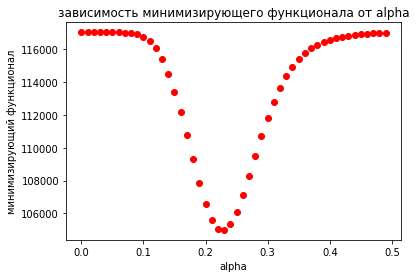

In [9]:
plt.plot(alpha_list, minimize_list, 'ro')
plt.title('зависимость минимизирующего функционала от alpha')
plt.xlabel('alpha')
plt.ylabel('минимизирующий функционал') # см. функцию  minimaze_func
# xlim(0, 0.2)
# ylim(5000, 10000)
plt.show()

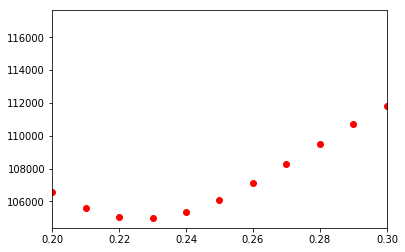

In [10]:
# более приближенный график
plt.plot(alpha_list, minimize_list, 'ro')
xlim(0.2, 0.3)
plt.show()

__Графики с $\alpha$ лежащим в промежутке $[0.22; 0.24]$ с шагом $h = 0.001$__

In [11]:
real_d_i_j = get_real_d_i_j(df)

alpha_list = []
minimize_list =[]
for alpha in np.arange(0.22, 0.24, 0.001):
    value = minimaze_func(real_d_i_j, alpha)
    print('alpha: ', alpha, 'min: ', value)
    alpha_list.append(alpha)
    minimize_list.append(value)

alpha:  0.22 min:  105067.58958337724
alpha:  0.221 min:  105038.49323935201
alpha:  0.222 min:  105014.09365270371
alpha:  0.223 min:  104994.39454984196
alpha:  0.224 min:  104979.39302151898
alpha:  0.225 min:  104969.0796079354
alpha:  0.226 min:  104963.438402835
alpha:  0.227 min:  104962.44717555228
alpha:  0.228 min:  104966.07750987848
alpha:  0.229 min:  104974.29495853576
alpha:  0.23 min:  104987.059211989
alpha:  0.231 min:  105004.32428028695
alpha:  0.232 min:  105026.03868660168
alpha:  0.233 min:  105052.14567113192
alpha:  0.234 min:  105082.58340404648
alpha:  0.23500000000000001 min:  105117.28520616889
alpha:  0.23600000000000002 min:  105156.17977614183
alpha:  0.23700000000000002 min:  105199.19142285848
alpha:  0.23800000000000002 min:  105246.24030200273
alpha:  0.23900000000000002 min:  105297.24265560528


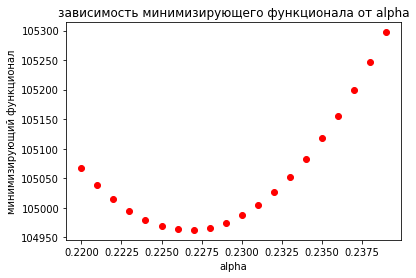

In [12]:
plt.plot(alpha_list, minimize_list, 'ro')
plt.title('зависимость минимизирующего функционала от alpha')
plt.xlabel('alpha')
plt.ylabel('минимизирующий функционал') # см. функцию  minimaze_func
# xlim(0, 0.2)
# ylim(5000, 10000)
plt.show()

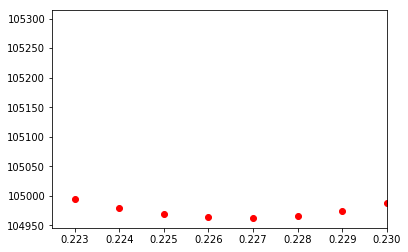

In [14]:
# более приближенный график
plt.plot(alpha_list, minimize_list, 'ro')
xlim(0.2225, 0.23)
plt.show()

__Графики с $\alpha$ лежащим в промежутке $[0.225; 0.228]$ с шагом $h = 0.001$__

In [15]:
real_d_i_j = get_real_d_i_j(df)

alpha_list = []
minimize_list =[]
for alpha in np.arange(0.225, 0.228, 0.001):
    value = minimaze_func(real_d_i_j, alpha)
    print('alpha: ', alpha, 'min: ', value)
    alpha_list.append(alpha)
    minimize_list.append(value)

alpha:  0.225 min:  104969.0796079354
alpha:  0.226 min:  104963.438402835
alpha:  0.227 min:  104962.44717555228
alpha:  0.228 min:  104966.07750987848


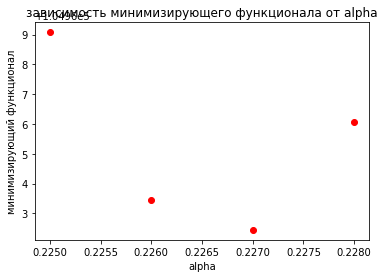

In [16]:
plt.plot(alpha_list, minimize_list, 'ro')
plt.title('зависимость минимизирующего функционала от alpha')
plt.xlabel('alpha')
plt.ylabel('минимизирующий функционал') # см. функцию  minimaze_func
# xlim(0, 0.2)
# ylim(5000, 10000)
plt.show()

__Графики с $\alpha$ лежащим в промежутке $[0.2265; 0.2275]$ с шагом $h = 0.0001$__

In [17]:
real_d_i_j = get_real_d_i_j(df)

alpha_list = []
minimize_list =[]
for alpha in np.arange(0.2265, 0.2275, 0.0001):
    value = minimaze_func(real_d_i_j, alpha)
    print('alpha: ', alpha, 'min: ', value)
    alpha_list.append(alpha)
    minimize_list.append(value)

alpha:  0.2265 min:  104962.3631747429
alpha:  0.2266 min:  104962.28735093803
alpha:  0.22669999999999998 min:  104962.25786877096
alpha:  0.22679999999999997 min:  104962.27469889115
alpha:  0.22689999999999996 min:  104962.33781134001
alpha:  0.22699999999999995 min:  104962.44717555228
alpha:  0.22709999999999994 min:  104962.60276035787
alpha:  0.22719999999999993 min:  104962.80453398326
alpha:  0.22729999999999992 min:  104963.05246405321
alpha:  0.2273999999999999 min:  104963.34651759252
alpha:  0.2274999999999999 min:  104963.68666102736


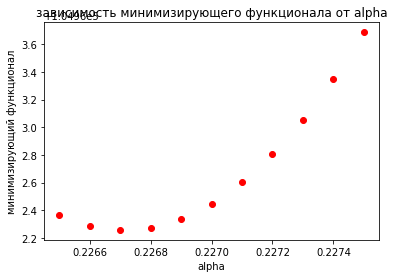

In [18]:
plt.plot(alpha_list, minimize_list, 'ro')
plt.title('зависимость минимизирующего функционала от alpha')
plt.xlabel('alpha')
plt.ylabel('минимизирующий функционал') # см. функцию  minimaze_func
# xlim(0, 0.2)
# ylim(5000, 10000)
plt.show()

__Графики с $\alpha$ лежащим в промежутке $[0.2266; 0.2268]$ с шагом $h = 0.00001$__

In [21]:
real_d_i_j = get_real_d_i_j(df)

alpha_list = []
minimize_list =[]
for alpha in np.arange(0.2266, 0.2268, 0.00001):
    value = minimaze_func(real_d_i_j, alpha)
    print('alpha: ', alpha, 'min: ', value)
    alpha_list.append(alpha)
    minimize_list.append(value)

alpha:  0.2266 min:  104962.28735093803
alpha:  0.22661 min:  104962.28231782715
alpha:  0.22662000000000002 min:  104962.27774810404
alpha:  0.22663000000000003 min:  104962.27364173962
alpha:  0.22664000000000004 min:  104962.26999870465
alpha:  0.22665000000000005 min:  104962.2668189699
alpha:  0.22666000000000006 min:  104962.26410250604
alpha:  0.22667000000000007 min:  104962.26184928368
alpha:  0.22668000000000008 min:  104962.26005927342
alpha:  0.22669000000000009 min:  104962.25873244567
alpha:  0.2267000000000001 min:  104962.25786877096
alpha:  0.2267100000000001 min:  104962.25746821958
alpha:  0.22672000000000012 min:  104962.25753076196
alpha:  0.22673000000000013 min:  104962.25805636824
alpha:  0.22674000000000014 min:  104962.25904500863
alpha:  0.22675000000000015 min:  104962.26049665333
alpha:  0.22676000000000016 min:  104962.26241127234
alpha:  0.22677000000000017 min:  104962.26478883573
alpha:  0.22678000000000018 min:  104962.2676293134
alpha:  0.226790000000

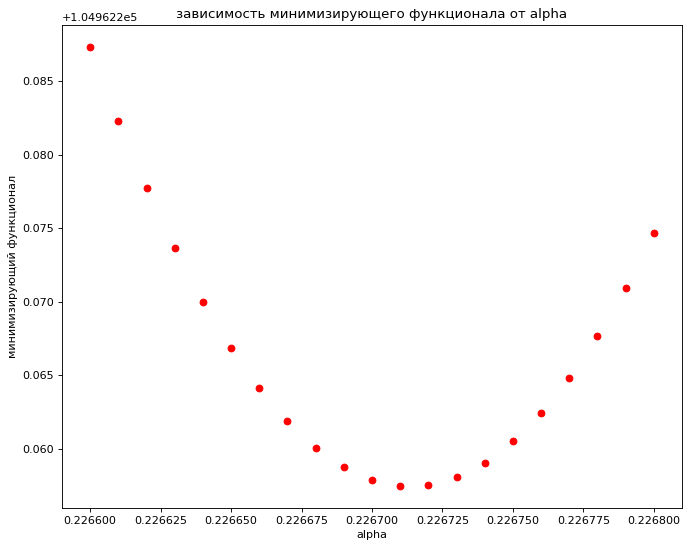

In [25]:
figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(alpha_list, minimize_list, 'ro')
plt.title('зависимость минимизирующего функционала от alpha')
plt.xlabel('alpha')
plt.ylabel('минимизирующий функционал') # см. функцию  minimaze_func
# xlim(0, 0.2)
# ylim(5000, 10000)
plt.show()

__Графики с $\alpha$ лежащим в промежутке $[0.226700; 0.226725]$ с шагом $h = 0.00001$__

In [26]:
real_d_i_j = get_real_d_i_j(df)

alpha_list = []
minimize_list =[]
for alpha in np.arange(0.226700, 0.226725, 0.00001):
    value = minimaze_func(real_d_i_j, alpha)
    print('alpha: ', alpha, 'min: ', value)
    alpha_list.append(alpha)
    minimize_list.append(value)

alpha:  0.2267 min:  104962.25786877096
alpha:  0.22671000000000002 min:  104962.2574682196
alpha:  0.22672000000000003 min:  104962.25753076196


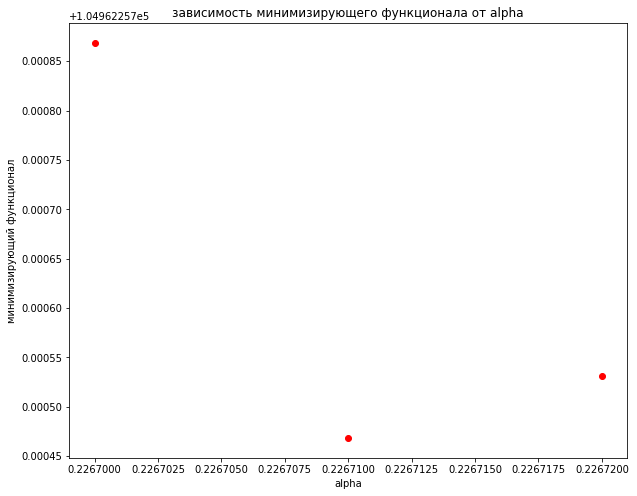

In [29]:
figure(figsize=(10, 8))
plt.plot(alpha_list, minimize_list, 'ro')
plt.title('зависимость минимизирующего функционала от alpha')
plt.xlabel('alpha')
plt.ylabel('минимизирующий функционал') # см. функцию  minimaze_func
# xlim(0, 0.2)
# ylim(5000, 10000)
plt.show()

__Итог: $\alpha = 0.22671$ показывает лучшие результаты__